## Human Activity Recognition Using Accelerometer and CNN

#### Prediction of Human Activity
In this project we are going to use accelometer data to train the model so that it can predict the human activity. We are going to use 2D Convolutional Neural Networks to build the model.

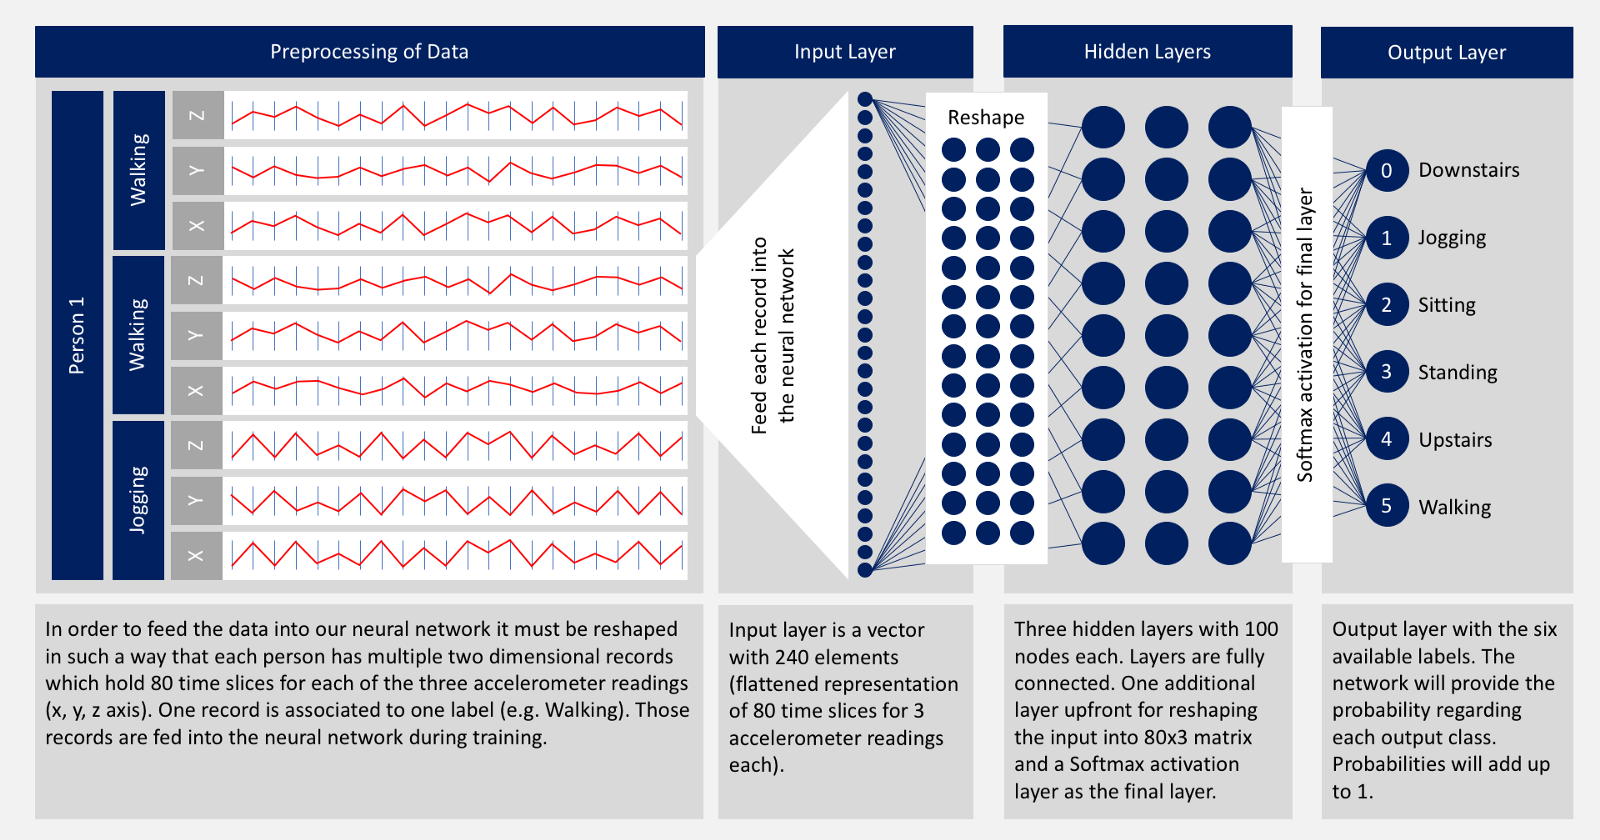

#### Dataset
Dataset Link: http://www.cis.fordham.edu/wisdm/dataset.php or https://github.com/laxmimerit/Human-Activity-Recognition-Using-Accelerometer-Data-and-CNN

This WISDM dataset contains data collected through controlled, laboratory conditions. The total number of examples is 1,098,207. The dataset contains six different labels (Downstairs, Jogging, Sitting, Standing, Upstairs, Walking).

 - pandas is used to read the dataset.
 - numpy is used to perform basic array operations.
 - pyplot from matplotlib is used to visualize the results.
 - train_test_split from sklearn is used split the data into training and testing dataset.
 - LabelEncoder from sklearn is used to encode target labels with value between 0 and number of classes-1.
 - StandardScaler from sklearn is used to bring all the data in the same scale.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPool2D,
)
from tensorflow.keras.optimizers import Adam

In [ ]:
print(tf.__version__)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Load and process the Dataset
If we try to read this data directly using pd.read_csv() we will get an error because this data is not pre-processed properly. So we will have to read this data into a native python file and then pre-process it.

Using open() we will first open the file. Then we will read all the lines of the file into the read variable. Now we will consider all the lines one by one using a for loop. For each line the following operations will be performed-

 - line = line.split(',') splits the line wherever there is a comma and returns an array of separated elements.
 - last = line[5].split(';')[0] removes the semicolon after the last element in the array.
 - last = last.strip() removes any extra space.
 - Then if last is not empty we copy all the elements into temp.
 - Now that the line is ready we append it to processedList
 
try and except is used for error handling. In this process if we get an error, the number of the line which is throwing that error is displayed.

In [ ]:
# Reading like this gives error because our original data is not properly formatted.
# Link to dataset - https://www.cis.fordham.edu/wisdm/dataset.php
pd.read_csv("data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt")

In [ ]:
# Some lines have multiple lines clubbed together as shown below
# 13,Downstairs,3498732310000,5.13,10.42,4.671779;15,Jogging,328982249000,5.37,-3.36,7.3141265;
# We need to process such lines to avoid above error.
# Reading file line by line

file = open("data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt")
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(",")  # Split by ","
        last = line[5].split(";")[
            0
        ]  # After 6th element split by ";" as we have ";" in our data shown above
        last = last.strip()  # Remove white space
        if last == "":
            break

        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print("Error at line number:", i)

In [ ]:
processedList

Now we have the processedList. It is a list of lists. Each inner list has the user ID, activity, timestamp and then the x, y, z data.

In [ ]:
columns = ["user", "activity", "time", "x", "y", "z"]

Now we have the processedList. It is a list of lists. Each inner list has the user ID, activity, timestamp and then the x, y, z data.

In [ ]:
data = pd.DataFrame(data=processedList, columns=columns)
data.head()

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
# Checking Null Values
data.isnull().sum()

In [ ]:
# As we can see the data is very unballanced. We need to balance the data so the maodel is accurate.
data["activity"].value_counts()

## Balance the data
From the data distribution shown above we can observe that the data is unbalanced. Standing has very less examples compared to Walking and Jogging'. If we use this data directly it will overfit and will be skewed towards Walking and Jogging'.

As we saw earlier the data is in string data type. Here we have converted the x, y, z values into floating values using astype('float').

In [ ]:
data["x"] = data["x"].astype("float")
data["y"] = data["y"].astype("float")
data["z"] = data["z"].astype("float")
data.info()

Now we will plot x, y, z for few seconds. The sampling rate of this data is 20Hz. So we have set a variable Fs=20. activities is a list of all the unique activities.

In [ ]:
Fs = 20

In [ ]:
# Plotting some of the data for each activity
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data["time"], data["x"], "X-Axis")
    plot_axis(ax1, data["time"], data["y"], "Y-Axis")
    plot_axis(ax2, data["time"], data["z"], "Z-Axis")
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y, "g")
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

In [ ]:
activities = data["activity"].value_counts().index
activities

Now we will plot x, y, z for each activity for 10 seconds.

In [ ]:
for activity in activities:
    data_for_plot = data[(data["activity"] == activity)][: Fs * 10]
    plot_activity(activity, data_for_plot)

In [ ]:
# Dropping unnecessary columns
df = data.drop(["user", "time"], axis=1).copy()
df.head()

In [ ]:
df["activity"].value_counts()

As this data is highly imbalanced we will take only the first 3555 lines for each activity into seperate lists. Then we will create a dataframe balanced_data using pd.DataFrame() and append all the lists to balanced_data. The final shape of balanced_data is 21330 rows and 4 columns.

In [ ]:
# To balance the dataset only taking 3555 of each activities.
Walking = df[df["activity"] == "Walking"].head(3555).copy()
Jogging = df[df["activity"] == "Jogging"].head(3555).copy()
Upstairs = df[df["activity"] == "Upstairs"].head(3555).copy()
Downstairs = df[df["activity"] == "Downstairs"].head(3555).copy()
Sitting = df[df["activity"] == "Sitting"].head(3555).copy()
Standing = df[df["activity"] == "Standing"].head(3555).copy()

In [ ]:
# Joining all the data now
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append(
    [Walking, Jogging, Upstairs, Downstairs, Sitting, Standing]
)
balanced_data.shape

In [ ]:
# Now we have our balanced dataset
balanced_data["activity"].value_counts()

In [ ]:
balanced_data.head()

In [ ]:
# Now activities are string values. we need to convert it to numbers.
from sklearn.preprocessing import LabelEncoder

As we can see above, the values in activity are of data type string. We will convert them into numeric values using LabelEncoder from sklearn which we have already imported. fit_tranform fits label encoder and returns encoded labels. We will add a new column in the dataset with the name label which will have the encoded values.

In [ ]:
label = LabelEncoder()
balanced_data["label"] = label.fit_transform(balanced_data["activity"])
balanced_data.head()

In [ ]:
label.classes_

## Data Standardization
Now we will bring all the values in X in the same range using StandardScaler() from sklearn which we have already imported. scaled_X contains the scaled values of x, y, z and the labels.

##### Standardizing our data to bring down the variance.

In [ ]:
x = balanced_data[["x", "y", "z"]]
y = balanced_data["label"]

In [ ]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

scaled_x = pd.DataFrame(data=x, columns=["x", "y", "z"])
scaled_x["label"] = y.values
scaled_x

## Frame Preperation

In [ ]:
import scipy.stats as stats

We will multiply the frequency by 4 seconds. Hence we will consider 80 observations at a time. Hop size will be 40 which means there will be some overlapping.

In [ ]:
# Since our data has time in seconds and a very few seconds timeline.
# We are only capturing the most performed activity for every 4 seconds.
# i.e., capture the activities done in every 4 seconds and then capture the most performed activities in that 4 seconds.
# Example: If in the given 4 seconds the person has performed Jumpping mostly
# then we will only capture the jumping and its corresponding data

Fs = 20
frame_size = Fs * 4  # Each 80 Samples
hop_size = Fs * 2  # Jump By 40 Samples

get_frames() creates frames of 4 seconds i.e. 80 observations with advancement of 40 observations. The label for this 4 seconds frame is the mode of the labels for the 80 observations which make the 4 seconds frame. get_frames() returns two np.arrays: frames containing all the 4 second frames and labels containing its corresponding labels. These are stored in X and y respectively. X contains 532 frames, each having 80 values of x, y, z. y containes 532 labels for the frames in X.

In [ ]:
def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3

    frames = []
    labels = []

    for i in range(0, len(df) - frame_size, hop_size):
        x = df["x"].values[i : i + frame_size]
        y = df["y"].values[i : i + frame_size]
        z = df["z"].values[i : i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df["label"][i : i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [ ]:
x, y = get_frames(scaled_x, frame_size, hop_size)

In [ ]:
x.shape, y.shape

We have 3555 observations for each of the 6 activities. Hence we have a total of (3555*6) observations. This divided by the hop_size which is 40 is approximately 532. Hence we have 532 frames in our data.

In [ ]:
# Above shape calulation is performed as below formula
# 3555 - Total Samples
# 6 - No of different activities
# 40 - Hop Size

(3555 * 6) / 40

Here we are dividing the data into training data and test data using train_test_split() from sklearn which we have already imported. We are going to use 80% of the data for training the model and 20% of the data for testing. random_state controls the shuffling applied to the data before applying the split. stratify = y splits the data in a stratified fashion, using y as the class labels.

We can see that we have got 425 samples in the traning dataset and 107 samples in the test dataset.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0, stratify=y
)

In [ ]:
# 425 - No. of arrays in an array
# 80 - No. of rows in an array
# 3 - No. of columns in an array (x, y, z values)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
# Shape of a array. Here we can see we have 2D array. We need to convert it to 3D array.
x_train[0].shape, x_test[0].shape, y_train[0].shape, y_test[0].shape

In [ ]:
# CNN needs 3D data. Converting 2D to 3D.
x_train = x_train.reshape(425, 80, 3, 1)
x_test = x_test.reshape(107, 80, 3, 1)

In [ ]:
x_train[0].shape, x_test[0].shape

## Build 2D CNN Model

A Sequential() model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

Conv2D() is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs. In image processing kernel is a convolution matrix or masks which can be used for blurring, sharpening, embossing, edge detection, and more by doing a convolution between a kernel and an image. In the first Conv2D() layer we are learning a total of 16 filters each having size (2,2). We will be using ReLu activation function. The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.

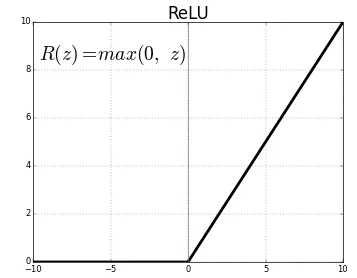

Dropout layer is used to by randomly set the outgoing edges of hidden units to 0 at each update of the training phase. The value passed in dropout specifies the probability at which outputs of the layer are dropped out.

Flatten() is used to convert the data into a 1-dimensional array for inputting it to the next layer.

Dense layer is the regular deeply connected neural network layer with 64 neurons. The output layer is also a dense layer with 6 neurons for the 6 classes. The activation function used is softmax. Softmax converts a real vector to a vector of categorical probabilities. The elements of the output vector are in range (0, 1) and sum to 1. Softmax is often used as the activation for the last layer of a classification network because the result could be interpreted as a probability distribution.

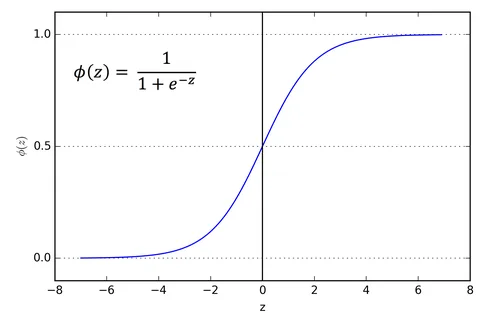

In [ ]:
model = Sequential()
model.add(
    Conv2D(16, kernel_size=[2, 2], activation="relu", input_shape=x_train[0].shape)
)
model.add(Dropout(0.1))

model.add(Conv2D(32, kernel_size=[2, 2], activation="relu"))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(6, activation="softmax"))

In [ ]:
model.summary()

Here we are compiling the model and fitting it to the training data. We will use 10 epochs to train the model. An epoch is an iteration over the entire data provided. validation_data is the data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. As metrics = ['accuracy'] the model will be evaluated based on the accuracy.

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
    x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=1
)

We will now plot the model accuracy and model loss. In model accuracy we will plot the training accuracy and validation accuracy and in model loss we will plot the training loss and validation loss.

In [ ]:
epoch_range = range(1, 11)

In [ ]:
# Plot training and validation accuracy values
# sparse_categorical_accuracy vs val_sparse_categorical_accuracy
plt.plot(epoch_range, history.history["accuracy"])
plt.plot(epoch_range, history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

In [ ]:
# Plot training and validation loss values
# Loss vs Val_Loss
plt.plot(epoch_range, history.history["loss"])
plt.plot(epoch_range, history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

## Confusion Matrix

 - A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known.
 - Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa)
 - The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another).
 - All correct predictions are located in the diagonal of the table, so it is easy to visually inspect the table for prediction errors, as they will be represented by values outside the diagonal. For two classes the confusion matrix looks like this-

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model.predict_classes(x_test)

In [ ]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(
    conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7, 7)
)

As you can see we are getting 100% accuracy for Sitting and Standing. The confusion matrix also tells us that our model is getting confused between Upstairs and Downstairs.

We have got a decent accuracy for this data. If you want to further increase the accuracy you can play around with many things. You can try traning the model with more data or you can even try tuning frame_size and hop_size.

Lastly, you can save the model using save_weights().